# Trabalho 1

- **nome:** Jessé P. B. Rocha
- **R.A.:** 2149389

- **descrição:** o trabalho consiste no desenvolvimento de um modelo para informar quais pessoas tinham mais chance de sobreviver no naufrágio do Titanic de acordo com dados fornecidos no dataset.

In [49]:
import pandas as pd
import numpy as np 
import imblearn as ibl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from sklearn.svm import SVC
import itertools
from joblib import Parallel, delayed
from sklearn.metrics import f1_score, classification_report
from scipy.stats import ttest_ind_from_stats

%matplotlib inline

</br>

**Primeiramente**, carregamos a base de dados e a separamos em atributos de entrada e saída. O atributo de saída é o *Survived* que, como o nome sugere, indica quem morreu e quem sobreviveu no naufrágio.

In [50]:
df = pd.read_csv("train.csv")
y = df[['Survived']].values.ravel()
X = df.drop(['Survived', 'PassengerId', 'Name'], axis=1)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


</br>

**Perceba** que, além de separar o dataset em dados de entrada e de saída, também foram removidos *PassengerId* e *Name*. Isso foi feito porque esses dados em nada nos acrescentam para a classificação. Saber o nome ou o identificador da pessoa (no dataset) não nos dá nenhuma informação relevante.

# Limpeza dos dados

Antes de iniciarmos a limpeza, vamos verificar como está nossa base de dados, no que diz respeito a dados faltantes.

In [51]:
X.isnull().sum().sum()

866

</br>

**Perceba** que realmente possuímos dados faltantes. Ainda, dos 891 registros, 866 possuem dados faltantes. Logo, a estratégia de remover tais registros não é uma opção que faça sentido para nosso caso. Nossa segunda opção é realizar imputação de dados. Essa será nossa opção, para que não precisemos descartar os registros.

Além disso, utilizaremos a técnica de imputação pelo valor mais frequente de cada atributo. Assim, conseguimos manter o comportamento do dataset antes da imputação (o valor que tinha maior frequência antes da imputação continua tendo maior frequência).

In [52]:
atributos_numericos = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
atributos_str = ['Ticket', 'Cabin', 'Sex', 'Embarked']

transformers = [
    ('imp_num', SimpleImputer(strategy='most_frequent'), atributos_numericos),
    ('imp_str', SimpleImputer(strategy='most_frequent'), atributos_str)
]

ct_imp = ColumnTransformer(
    transformers, remainder='passthrough'
)

X_imp_vals = ct_imp.fit_transform(X)
X_imputed = pd.DataFrame(X_imp_vals, columns=[*atributos_numericos, *atributos_str])

</br>

**Vejamos** como ficou nossa base de dados, após a imputação.

In [53]:
X_imputed

,Pclass,Age,SibSp,Parch,Fare,Ticket,Cabin,Sex,Embarked
0,3.0,22.0,1.0,0.0,7.25,A/5 21171,B96 B98,male,S
1,1.0,38.0,1.0,0.0,71.2833,PC 17599,C85,female,C
2,3.0,26.0,0.0,0.0,7.925,STON/O2. 3101282,B96 B98,female,S
3,1.0,35.0,1.0,0.0,53.1,113803,C123,female,S
4,3.0,35.0,0.0,0.0,8.05,373450,B96 B98,male,S
...,...,...,...,...,...,...,...,...,...
886,2.0,27.0,0.0,0.0,13.0,211536,B96 B98,male,S
887,1.0,19.0,0.0,0.0,30.0,112053,B42,female,S
888,3.0,24.0,1.0,2.0,23.45,W./C. 6607,B96 B98,female,S
889,1.0,26.0,0.0,0.0,30.0,111369,C148,male,C


</br>

**Por** garantia, vamos mais uma vez verificar se existem dados faltantes.

In [54]:
X_imputed.isnull().sum().sum()

0

</br>

**Como** pode-se ver, não há nenhum registro com dados faltantes. Logo, podemos seguir em frente.

# Conversão dos dados categóricos

Agora vamos realizar a conversão dos dados categóricos em numéricos. Perceba que *Sex, Embarked, Ticket e Cabin* são atributos categóricos nominais. Eles, portanto, serão codificados usando o *One-Hot Endcoder*. Já o atributo *Pclass* é um categórico ordinal. Isso em razão da relação de ordem existente nele, no que diz respeito ao poder aquisitivo. Os da primeira classe são os mais afortunados e os da terceira, os menos. Assim sendo, sua codificação será feita usando o *Ordinal Encoder*.

In [55]:
transformers = [
    ('od_class', OrdinalEncoder(), ['Pclass']),
    ('oh_sex', OneHotEncoder(), ['Sex']),
    ('oh_embarked', OneHotEncoder(), ['Embarked']),
    ('oh_ticket', OneHotEncoder(), ['Ticket']),
    ('oh_cabin', OneHotEncoder(), ['Cabin']),
]

ct_oh = ColumnTransformer(
    transformers, remainder='passthrough'
)

X_oh = ct_oh.fit_transform(X_imputed).todense()

</br>

**Feito** isso, podemos ver o resultado da codificação.

In [56]:
X_oh

matrix([[ 2.    ,  0.    ,  1.    , ...,  1.    ,  0.    ,  7.25  ],
        [ 0.    ,  1.    ,  0.    , ...,  1.    ,  0.    , 71.2833],
        [ 2.    ,  1.    ,  0.    , ...,  0.    ,  0.    ,  7.925 ],
        ...,
        [ 2.    ,  1.    ,  0.    , ...,  1.    ,  2.    , 23.45  ],
        [ 0.    ,  0.    ,  1.    , ...,  0.    ,  0.    , 30.    ],
        [ 2.    ,  0.    ,  1.    , ...,  0.    ,  0.    ,  7.75  ]])

# Exploração

Agora, vamos explorar um pouco nossa base de dados para conhecê-la melhor.

## Scatter Plot

/home/jessepbr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/jessepbr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


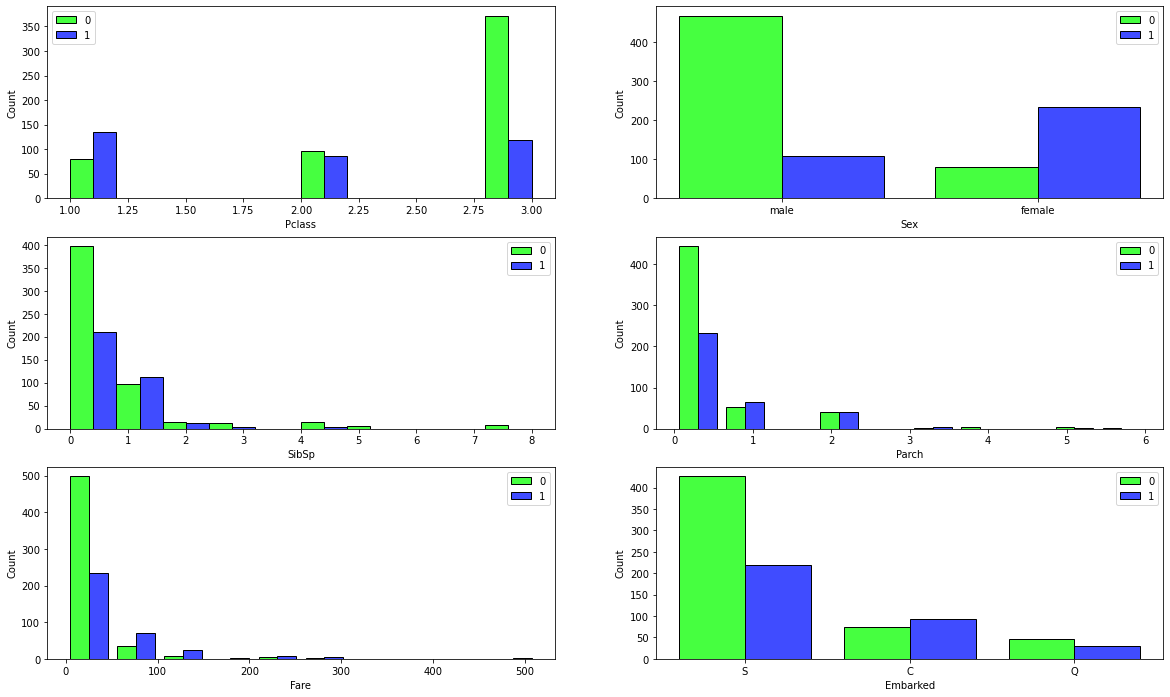

In [57]:
ss = StandardScaler()
ss.fit(X_oh)
X_ss = ss.transform(X_oh)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 12))
sns.histplot(data=X_imputed, bins=10, x="Pclass", hue=y, multiple="dodge", shrink=1, ax=axes[0][0], palette="hsv")
sns.histplot(data=X_imputed, bins=10, x="Sex", hue=y, multiple="dodge", shrink=0.8, ax=axes[0][1], palette="hsv")
sns.histplot(data=X_imputed, bins=10, x="SibSp", hue=y, multiple="dodge", shrink=1, ax=axes[1][0], palette="hsv")
sns.histplot(data=X_imputed, bins=10, x="Parch", hue=y, multiple="dodge", shrink=0.8, ax=axes[1][1], palette="hsv")
sns.histplot(data=X_imputed, bins=10, x="Fare", hue=y, multiple="dodge", shrink=0.8, ax=axes[2][0], palette="hsv")
sns.histplot(data=X_imputed, bins=10, x="Embarked", hue=y, multiple="dodge", shrink=0.8, ax=axes[2][1], palette="hsv")

plt.show()

</br>

**Do** que temos até o momento, podemos dizer que, no que diz respeito à classe, as pessoas da terceira classe foram as que menos sobreviveram, mulheres sobreviveram mais do que crianças, as pessoas que viajaram sozinhas também foram as que mais sobreviveram. Os que pagaram mais caro no bilhete de embarque também compõem o número dos que sobreviveram. Note que, conforme o valor do bilhete aumenta, o número de sobreviventes começa a superar o número de mortos. Aparentemente, os atributos que dizem respeito ao poder aquisitivo do indivíduo, seu sexo e quantidade de familiares à bordo nos dão as melhores respostas.

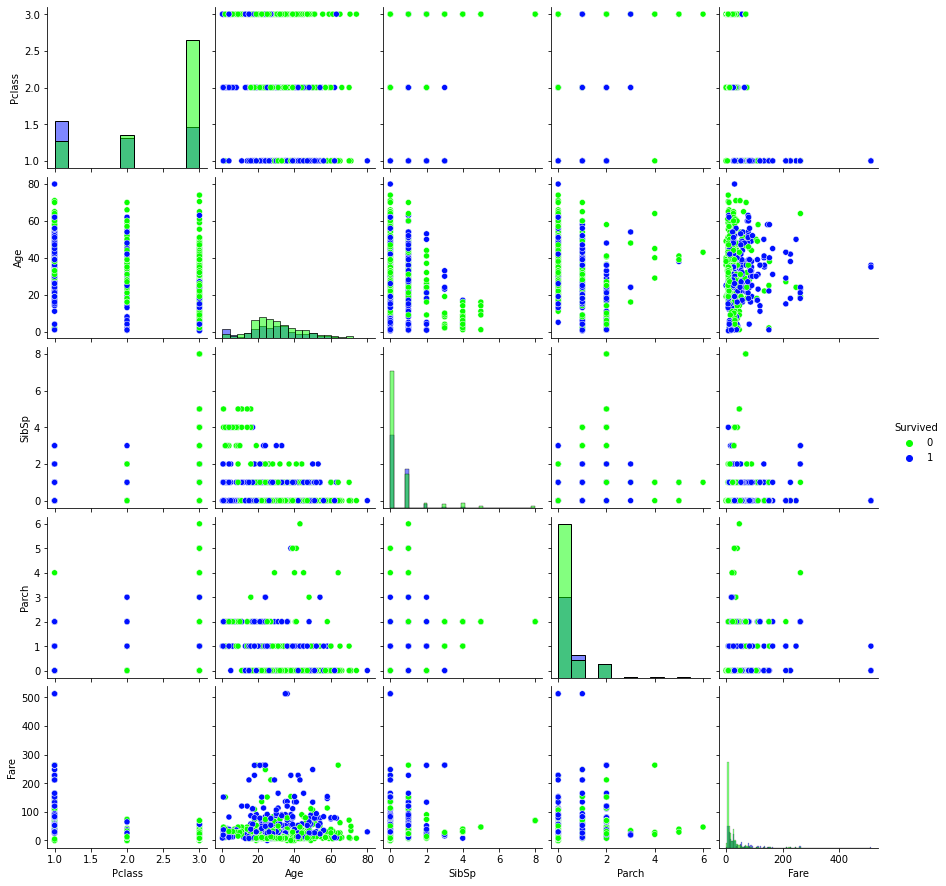

In [58]:
df_pair_plot = df.drop(['Name', 'PassengerId', 'Ticket', 'Cabin', 'Sex', 'Embarked'], axis=1)
sns.pairplot(df_pair_plot,
             hue="Survived",
             palette="hsv",
             diag_kind="hist")

</br>

**Perceba** que as combinações de atributos com *Pclass* estão com os dados consideravelmente bem separados. A maioria das mortes é de passageiros da segunda e terceira classe. Perceba também que, em qualquer combinação que envolva *Fare*, as mortes diminuem conforme o preço do bilhete aumenta. As combinações com *SibSp* também comprovam o que já havia sido comentado na etapa anterior da exploração. Quanto maior for *SibSp*, menor as chances de sobreviver. Percebe-se, portanto, que a combinação de atributos que dizem respeito da condição financeira e da família do indivíduo fornecem bons resultados.

# Classificadores

Agora vamos aplicar dois classificadores, o *KNN* e o *SVM*. Para os dois classificadores, aplicaremos a técnica de validação cruzada dupla.

## KNN

In [59]:
def executa_cvd_knn(X, y, cv_splits, ks, n_jobs=8, range_option=range(1, 30, 2)):    
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)
    f1s_knn = []
    class_report_knn = []
    folds_knn = 0
    melhor_comb_knn = {}

    pgb = tqdm(total=cv_splits, desc='Folds avaliados')
    
    for idx_treino, idx_teste in skf.split(X, y):
        X_treino = X[idx_treino]
        y_treino = y[idx_treino]

        X_teste = X[idx_teste]
        y_teste = y[idx_teste]

        X_treino, X_val, y_treino, y_val = train_test_split(
            X_treino,
            y_treino,
            stratify=y_treino,
            test_size=0.2,
            random_state=1
        )

        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)
        X_val = ss.transform(X_val)

        combinacoes = {'n_neighbors': range_option}
        score = 'f1' if len(set(y_treino)) < 3 else 'f1_weighted'

        knn = KNeighborsClassifier()
        knn = GridSearchCV(knn, combinacoes, cv=StratifiedKFold(n_splits=cv_splits), n_jobs=n_jobs, scoring=score)
        knn.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
        pred = knn.predict(X_teste)
        melhor_comb_knn[knn.best_score_] = knn.best_params_

        if len(set(y_treino)) > 2:
            f1 = f1_score(y_teste, pred, average='weighted')
        else:
            f1 = f1_score(y_teste, pred)
        f1s_knn.append(f1)
        class_report_knn.append(classification_report(y_teste, pred))
        folds_knn += 1
        
        pgb.update(1)
    pgb.close()
    
    return f1s_knn, class_report_knn, folds_knn, knn, melhor_comb_knn

## SVM

Faremos o mesmo processo feito para o *KNN* para realizar a validação cruzada em dois níveis.

In [60]:
def executa_cvd_svm(X, y, cv_splits, params, n_jobs=8):
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)
    f1s_svm = []
    class_report_svm = []
    folds_svm = 0
    melhor_comb_svm = {}
    
    pgb = tqdm(total=cv_splits, desc='Folds avaliados')
    
    for idx_treino, idx_teste in skf.split(X, y):
        X_treino = X[idx_treino]
        y_treino = y[idx_treino]
        
        X_teste = X[idx_teste]
        y_teste = y[idx_teste]
        
        X_treino, X_val, y_treino, y_val = train_test_split(
            X_treino,
            y_treino,
            stratify=y_treino,
            test_size=0.2,
            random_state=1
        )
        
        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)
        X_val = ss.transform(X_val)
        
        score = 'f1' if len(set(y_treino)) < 3 else 'f1_weighted'
        svm = GridSearchCV(SVC(), param_grid=params, cv=StratifiedKFold(n_splits=cv_splits), n_jobs=n_jobs, scoring=score)
        svm.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
        pred = svm.predict(X_teste)
        melhor_comb_svm[svm.best_score_] = svm.best_params_
        
        if len(set(y_treino)) > 2:
            f1 = f1_score(y_teste, pred, average='weighted')
        else:
            f1 = f1_score(y_teste, pred)
        f1s_svm.append(f1)
        class_report_svm.append(classification_report(y_teste, pred))
        folds_svm += 1
        
        pgb.update(1)
    pgb.close()
    
    return f1s_svm, class_report_svm, folds_svm, svm, melhor_comb_svm

# Seleção do melhor modelo

O que faremos agora é selecionar o melhor modelo, gerado pelas funções implementadas acima (que serão executadas abaixo), com base em análise estatística. Utilizaremos para tanto, o Teste de Hipótese Nula pelo *Teste t de Student*.

In [61]:
f1s_knn, class_report_knn, folds_knn, knn, melhor_comb_knn = executa_cvd_knn(X_oh, y, 10, range(1, 30, 2))

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/home/jessepbr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/jessepbr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/jessepbr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/hom

In [62]:
f1s_svm, class_report_svm, folds_svm, svm, melhor_comb_svm = executa_cvd_svm(X_oh,
                                                            y,
                                                            10,
                                                            params={'C' : [1, 10, 100, 1000], 'gamma' : ['auto', 'scale', 2e-2, 2e-3, 2e-4], 'kernel': ['rbf']})

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/home/jessepbr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/jessepbr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/jessepbr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/hom

In [63]:
def calcular_estatisticas(resultados):
    return np.mean(resultados), np.std(resultados), np.min(resultados), np.max(resultados)

def imprimir_estatisticas(resultados):
    media, desvio, mini, maxi = calcular_estatisticas(resultados)
    print("Resultados: %.2f +- %.2f, min: %.2f, max: %.2f" % (media, desvio, mini, maxi))

</br>

**Antes**, vamos conferir as estatíticas de cada um dos classificadores. Lembre-se que estamos utilzando *f1 score* como a métrica de classificação. Portanto serão exibidos o menor *f1 score*, bem como o maior, a média e o desvio padrão.

In [64]:
imprimir_estatisticas(f1s_knn)
imprimir_estatisticas(f1s_svm)

Resultados: 0.69 +- 0.08, min: 0.55, max: 0.83
Resultados: 0.77 +- 0.05, min: 0.71, max: 0.89


</br>

**Agora** vamos utilizar o *Teste t de Student* para ver qual dos modelos possui o melhor resultado, se são os modelos gerados com o *KNN* ou com o *SVM*. Para isso, vamos implementar uma função que realiza tal teste.

In [65]:
def rejeitar_hipotese_nula(amostra1, amostra2, alpha=0.05):
    media_amostral1, desvio_padrao_amostral1, _, _ = calcular_estatisticas(amostra1)
    media_amostral2, desvio_padrao_amostral2, _, _ = calcular_estatisticas(amostra2)
    
    statistic, pvalor = ttest_ind_from_stats(media_amostral1, desvio_padrao_amostral1, len(amostra1), media_amostral2, desvio_padrao_amostral2, len(amostra2))
    resultado = pvalor <= alpha
    return statistic, resultado, pvalor

In [66]:
def seleciona_melhor_modelo(amostra_1, amostra_2, alpha=0.05):
    statistic, resultado, pvalor = rejeitar_hipotese_nula(amostra_1, amostra_2)
    
    if resultado == True:
        if statistic > 0:
            return "amostra 1"
        else:
            return "amostra 2"
    else:
        return "Não há diferença estatisticamente significativa"

In [67]:
melhor_modelo = seleciona_melhor_modelo(f1s_knn, f1s_svm)
melhor_modelo

'amostra 2'

</br>

**Perceba** que os dois modelos possuem um diferença estatisticamente significativa. Perceba também que o a amostra 2 é o melhor modelo. Na amostra 2, temos os *f1 scores* do *SVM*. Logo, o modelo que utiliza o classificador *SVM* é o melhor dos dois modelos.

# Resultados da classificação

Vejamos agora, as métricas de classificação para cada um dos modelos. Veremos as métricas por classe e do classificador como um todo.

In [68]:
def metricas_por_fold(class_report, qtd_folds):
    for i in range(qtd_folds):
        print("============================fold %d:============================" % (i+1))
        print(class_report[i], "\n")

## Métricas de classificação de cada fold do KNN

In [69]:
metricas_por_fold(class_report_knn, folds_knn)

============================fold 1:============================
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        55
           1       0.69      0.69      0.69        35

    accuracy                           0.76        90
   macro avg       0.74      0.74      0.74        90
weighted avg       0.76      0.76      0.76        90
 

============================fold 2:============================
              precision    recall  f1-score   support

           0       0.83      0.73      0.78        55
           1       0.63      0.76      0.69        34

    accuracy                           0.74        89
   macro avg       0.73      0.75      0.74        89
weighted avg       0.76      0.74      0.74        89
 

============================fold 3:============================
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        55
           1       0.67      0.53      0.

## Métricas de classificação de cada fold do SVM

In [70]:
metricas_por_fold(class_report_svm, folds_svm)

============================fold 1:============================
              precision    recall  f1-score   support

           0       0.82      0.85      0.84        55
           1       0.76      0.71      0.74        35

    accuracy                           0.80        90
   macro avg       0.79      0.78      0.79        90
weighted avg       0.80      0.80      0.80        90
 

============================fold 2:============================
              precision    recall  f1-score   support

           0       0.86      0.91      0.88        55
           1       0.84      0.76      0.80        34

    accuracy                           0.85        89
   macro avg       0.85      0.84      0.84        89
weighted avg       0.85      0.85      0.85        89
 

============================fold 3:============================
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        55
           1       0.77      0.68      0.

**Disso** tudo, uma coisa que se poode concluir, é que o classificador *SVM* possui um melhor desempenho na classificação para os dados informados, conseguindo  acertar mais quem provavelmente ficou sobreviveu ou não ao naufrágio do Titanic.